## Learning to Forecast Electricity Demand Using Convolutional Neural Network Approach

### Goal
The goal of this project is to detect electricity demand anomalies based on historical data. The code consists of two parts: forecasting using a convolutional neural network (CNN) model and identifying anomalies. While CNN models are often used for image processing, they can be applied to sequence data by considering them as 1D images.

### Basics about CNNs
Similar to LSTMs, CNNs are a variant of neural network approaches that use convolution operators within hidden layers. At a high level, neural networks use a network of neurons that store information in numerical form to detect patterns across different hidden layers between the input and output layers. The neurons in each layer are based on the neurons in the previous layer, described by weights for activation and biases for inactivation in an activation function, such as ReLU or sigmoid. Weights and biases are estimated based on training data. The cost function, which measures differences between the model's predictions and the desired output based on training data, needs to be minimized and can be done using gradient descent.

For CNN models, hidden layers use convolution operators to detect patterns. Each convolutional layer uses a number of filters or kernels, which are matrices of weights with a specific size, to extract patterns. Filters slide over inputs from the previous layer to generate outputs for the next layer. Filters are initially created randomly and are evolved during training to capture more sophisticated patterns in deeper layers through backpropagation.

In addition to convolutional layers, pooling layers downsample the input to reduce the dimensionality of feature maps. A flatten layer converts the previous layer's output to a 1D structure. Dense layers process the flattened output for the final output layer.

### Steps
The steps for this code are similar to those using other algorithms, starting from data preparation, data division for training and testing the model, model running, and model evaluation. An additional step in this code is to identify anomalies based on the model predictions.

In [1]:
### set up environment
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
### load the data
# save the data locally and load it directly?

# fix random seed for reproducibility
tf.random.set_seed(7)

# load data
# hourly energy demand data
energy_data_url = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv'
energy_data = pd.read_csv(energy_data_url)

# use Austria as an example
AT_energy_data = energy_data[['utc_timestamp', 'AT_load_actual_entsoe_transparency']]

# time format
AT_energy_data['utc'] = pd.to_datetime(AT_energy_data['utc_timestamp'])

# hourly weather data
weather_data_url = 'https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv'
weather_data = pd.read_csv(weather_data_url)  # replace with your file path
AT_weather_data = weather_data[['utc_timestamp', 'AT_temperature']]
AT_weather_data['utc'] = pd.to_datetime(AT_weather_data['utc_timestamp'])

# merge demand and weather data
AT_data = pd.merge(AT_energy_data, AT_weather_data, on='utc')

<ipython-input-2-23865c708f33>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_energy_data['utc'] = pd.to_datetime(AT_energy_data['utc_timestamp'])
<ipython-input-2-23865c708f33>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_weather_data['utc'] = pd.to_datetime(AT_weather_data['utc_timestamp'])


In [3]:
# Feature engineering
AT_data['Hour'] = AT_data['utc'].dt.hour
AT_data['DayOfWeek'] = AT_data['utc'].dt.dayofweek
AT_data['DayOfMonth'] = AT_data['utc'].dt.day
AT_data['Month'] = AT_data['utc'].dt.month

# drop NaN before modeling
AT_data = AT_data.dropna()

# Verify that all columns are numerical
print(AT_data.dtypes)

utc_timestamp_x                                    object
AT_load_actual_entsoe_transparency                float64
utc                                   datetime64[ns, UTC]
utc_timestamp_y                                    object
AT_temperature                                    float64
Hour                                                int32
DayOfWeek                                           int32
DayOfMonth                                          int32
Month                                               int32
dtype: object


In [5]:
# Feature scaling
scaler = MinMaxScaler()  # same as scaler = MinMaxScaler(feature_range=(0, 1)), default is (0, 1)

# Drop the original datetime column
AT_data_drop = AT_data.drop(columns=['utc', 'utc_timestamp_x', 'utc_timestamp_y'])

data_scaled = scaler.fit_transform(AT_data_drop)
print(data_scaled.shape)
print(len(data_scaled))

(43824, 6)
43824


In [6]:
# Create sequences for supervised learning
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(data[i + window_size, 0])  # assuming the first column is demand
    return np.array(sequences), np.array(labels)

window_size = 24  # Using past 24 hours to predict the next hour

# X: inputs based on previous 24 hours, y: output
X, y = create_sequences(data_scaled, window_size)
print(X.shape)

(43800, 24, 6)


Given that historical electricity demand data is sequence data, I used Keras’ Conv1D function in my code. The model summary below shows the included layers. In this setup, I have one convolutional layer for simplicity, using 64 filters, each of size 3. As with my LSTM project, I use the Adam optimizer to minimize the loss function in terms of mean square error.

In [10]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(X_train.shape)

# Build the CNN model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()

(35040, 24, 6)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 22, 64)            1216      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 11, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 704)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                35250     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 36517 (142.64 KB)
Trainable params: 36517 (142.64 KB)
Non-trainable params: 0 (0.00 Byte)
_

In [11]:
# Train the model
cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1095/1095 [==============================] - 5s 4ms/step - loss: 0.0033 - val_loss: 5.3716e-04
Epoch 2/10
1095/1095 [==============================] - 5s 5ms/step - loss: 7.0734e-04 - val_loss: 3.3192e-04
Epoch 3/10
1095/1095 [==============================] - 6s 5ms/step - loss: 5.3513e-04 - val_loss: 2.6374e-04
Epoch 4/10
1095/1095 [==============================] - 4s 4ms/step - loss: 4.8552e-04 - val_loss: 2.6363e-04
Epoch 5/10
1095/1095 [==============================] - 5s 5ms/step - loss: 4.0012e-04 - val_loss: 5.6551e-04
Epoch 6/10
1095/1095 [==============================] - 4s 4ms/step - loss: 3.9264e-04 - val_loss: 3.1791e-04
Epoch 7/10
1095/1095 [==============================] - 4s 4ms/step - loss: 3.6395e-04 - val_loss: 2.8032e-04
Epoch 8/10
1095/1095 [==============================] - 5s 5ms/step - loss: 3.2011e-04 - val_loss: 2.1512e-04
Epoch 9/10
1095/1095 [==============================] - 4s 4ms/step - loss: 3.0698e-04 - val_loss: 2.1063e-04
Epoch 10/10
10

274/274 [==============================] - 1s 2ms/step
CNN Test MSE: 0.00012023398514109319
 CNN Test MAE: 0.00831172698275422
CNN Accuracy:98.71%


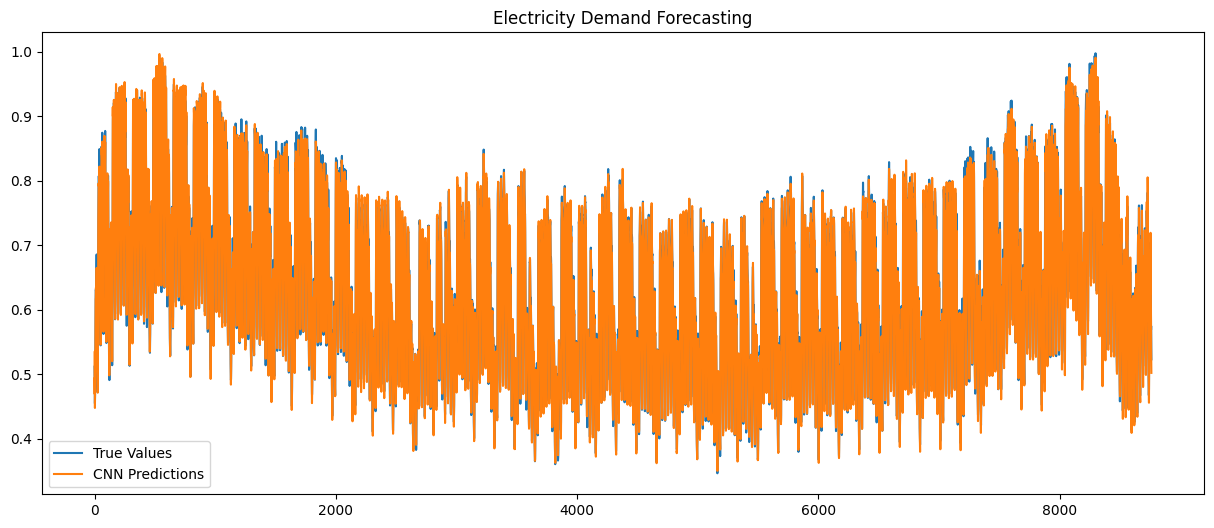

In [12]:
# Predict and evaluate CNN model
cnn_predictions = cnn_model.predict(X_test)
cnn_mse = mean_squared_error(y_test, cnn_predictions)
print(f'CNN Test MSE: {cnn_mse}')

cnn_mae = mean_absolute_error(y_test, cnn_predictions)
print(f" CNN Test MAE: {cnn_mae}")
accuracy_percent = (1 - (cnn_mae/y_test.mean()))*100
print(f'CNN Accuracy:{accuracy_percent:.2f}%')

# Plot predictions
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True Values')
plt.plot(cnn_predictions, label='CNN Predictions')
plt.legend()
plt.title('Electricity Demand Forecasting')
plt.show()

The model accuracy is 98.71%, higher than the LSTM. I can experiment with the number of convolutional layers and hyperparameters to see if the model performance improves.

In [19]:
### detect anomalies
# Make predictions
y_pred = cnn_model.predict(X_test)

# Calculate the reconstruction error
errors = np.abs(y_test - y_pred.flatten())

# Set a threshold for anomalies (e.g., 95th percentile of the errors)
threshold = np.percentile(errors, 95)
anomalies = errors > threshold

print(f'Number of anomalies detected: {np.sum(anomalies)}')


274/274 [==============================] - 2s 7ms/step
(8760,)
Number of anomalies detected: 438


(8760,)


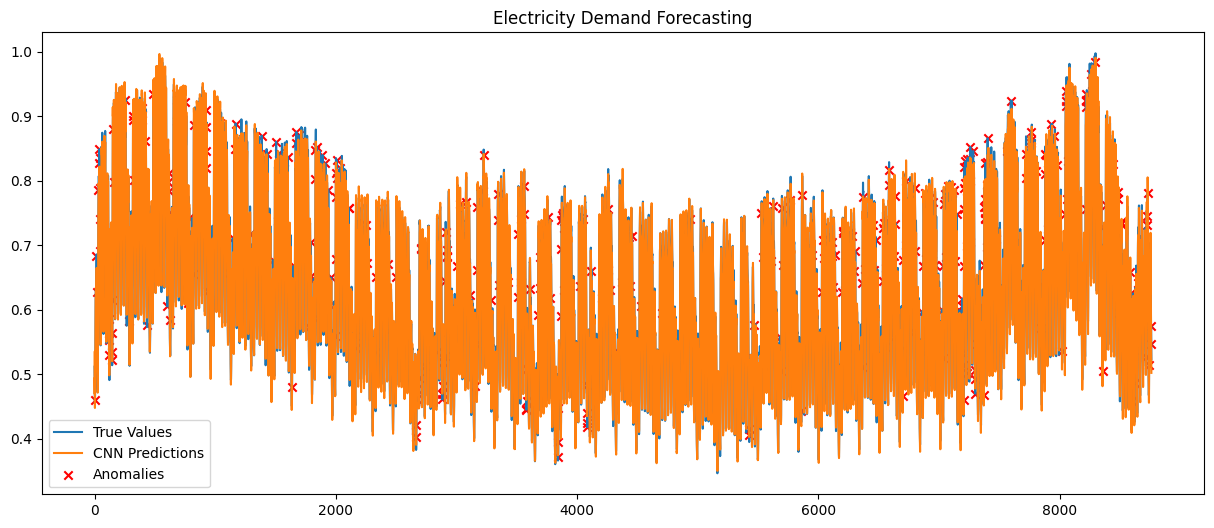

In [20]:
# Select a sample of anomalous instances for explanation
# Plot predictions and actual demands
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True Values')
plt.plot(cnn_predictions, label='CNN Predictions')
print(anomalies.shape)

# Mark anomalies
anomalous_points = np.where(anomalies)[0]
plt.scatter(anomalous_points, y_test[anomalous_points], color='red', label='Anomalies', marker='x')
plt.legend()
plt.title('Electricity Demand Forecasting')
plt.show()

The predictions by the CNN model capture normal variations. Therefore, large differences between actual and predicted demand indicate potential anomalies.